# Operator Inference with Optimization for Burger's Equation

Here we implment the operator inference solved with a non-constrained optimization approach rather than a linear least square approach shown in [Notebook 02](02_burgers_OpInf_LS.ipynb). This is the reproduction of the results from [Peherstorfer and Willcox](https://www.sciencedirect.com/science/article/pii/S0045782516301104?via%3Dihub).

## Initial Setup

In [1]:
using DataFrames
using LinearAlgebra
using Plots
using Random
using SparseArrays
using Statistics
using NaNStatistics

include("../src/model/Burgers.jl")
include("../src/LiftAndLearn.jl")
const LnL = LiftAndLearn

# First order Burger's equation setup
burger = Burgers(
    [0.0, 1.0], [0.0, 1.0], [0.1, 1.0],
    2^(-7), 1e-4, 1, "dirichlet"
);

## Non-Constrained Optimization

In [17]:
num_inputs = 3
rmax = 10

options = LnL.NC_options(
    system=LnL.sys_struct(
        is_lin=true,
        is_quad=true,
        has_control=true,
        has_output=true,
    ),
    vars=LnL.vars(
        N=1,
    ),
    data=LnL.data(
        Δt=1e-4,
        deriv_type="SI",
        DS=100,
    ),
    optim=LnL.opt_settings(
        verbose=false,
        initial_guess=false,
    ),
)


Main.LiftAndLearn.NC_options
  method: String "NC"
  system: Main.LiftAndLearn.sys_struct
  vars: Main.LiftAndLearn.vars
  data: Main.LiftAndLearn.data
  optim: Main.LiftAndLearn.opt_settings
  λ_lin: Int64 0
  λ_quad: Int64 0


In [ ]:

Utest = ones(burger.Tdim - 1, 1);  # Reference input/boundary condition for OpInf testing 

# Error Values 
k = 3
proj_err = zeros(rmax - k, burger.Pdim)
intru_state_err = zeros(rmax - k, burger.Pdim)
opinf_state_err = zeros(rmax - k, burger.Pdim)
intru_output_err = zeros(rmax - k, burger.Pdim)
opinf_output_err = zeros(rmax - k, burger.Pdim)

# Downsampling rate
DS = options.data.DS

println("[INFO] Compute inferred and intrusive operators and calculate the errors")
# for i in 1:length(burger.μs)
i=1
μ = burger.μs[i]

## Create testing data
A, B, F = burger.generateABFmatrix(burger, μ)
C = ones(1, burger.Xdim) / burger.Xdim
Xtest = LnL.semiImplicitEuler(A, B, F, Utest, burger.t, burger.IC)
Ytest = C * Xtest

op_burger = LnL.operators(A=A, B=B, C=C, F=F)

## training data for inferred dynamical models
Urand = rand(burger.Tdim - 1, num_inputs)
Xall = Vector{Matrix{Float64}}(undef, num_inputs)
Xdotall = Vector{Matrix{Float64}}(undef, num_inputs)
for j in 1:num_inputs
    states = burger.semiImplicitEuler(A, B, F, Urand[:, j], burger.t, burger.IC)
    tmp = states[:, 2:end]
    Xall[j] = tmp[:, 1:DS:end]  # downsample data
    tmp = (states[:, 2:end] - states[:, 1:end-1]) / burger.Δt
    Xdotall[j] = tmp[:, 1:DS:end]  # downsample data
end
X = reduce(hcat, Xall)
R = reduce(hcat, Xdotall)
Urand = Urand[1:DS:end, :]  # downsample data
U = vec(Urand)[:,:]  # vectorize
Y = C * X

# compute the POD basis from the training data
tmp = svd(X)
Vrmax = tmp.U[:, 1:rmax]

# Compute the values for the intrusive model from the basis of the training data
op_int = LnL.intrusiveMR(op_burger, Vrmax, options)

# Compute the inferred operators from the training data
if options.optim.reproject
    op_inf = LnL.inferOp(X, U, Y, Vrmax, op_burger, options)  # Using Reprojection
else
    op_inf = LnL.inferOp(X, U, Y, Vrmax, Vrmax' * R, options)  # without reprojection
end

for j = 1+k:rmax
    Vr = Vrmax[:, 1:j]  # basis
    
    # Integrate the intrusive model
    Fint_extract = LnL.extractF(op_int.F, j)
    Xint = burger.semiImplicitEuler(op_int.A[1:j, 1:j], op_int.B[1:j, :], Fint_extract, Utest, burger.t, Vr' * burger.IC)  # use F
    Yint = op_int.C[1:1, 1:j] * Xint
    
    # Integrate the inferred model
    Finf_extract = LnL.extractF(op_inf.F, j)
    Xinf = burger.semiImplicitEuler(op_inf.A[1:j, 1:j], op_inf.B[1:j, :], Finf_extract, Utest, burger.t, Vr' * burger.IC)  # use F
    Yinf = op_inf.C[1:1, 1:j] * Xinf

    # Compute errors
    PE, ISE, IOE, OSE, OOE = LnL.compError(Xtest, Ytest, Xint, Yint, Xinf, Yinf, Vr)

    # Sum of error values
    proj_err[j-k, i] = PE
    intru_state_err[j-k, i] = ISE
    intru_output_err[j-k, i] = IOE
    opinf_state_err[j-k, i] = OSE
    opinf_output_err[j-k, i] = OOE
end
# end

In [20]:
options = LnL.EPHEC_options(
    system=LnL.sys_struct(
        is_lin=true,
        is_quad=true,
        has_control=true,
        has_output=true,
    ),
    vars=LnL.vars(
        N=1,
    ),
    data=LnL.data(
        Δt=1e-4,
        deriv_type="SI",
        DS=100,
    ),
    optim=LnL.opt_settings(
        verbose=false,
        initial_guess=false,
    ),
)
op_inf = LnL.inferOp(X, U, Y, Vrmax, Vrmax' * R, options)  # without reprojection

┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:24


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:139
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:141


┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Hard Equality Constraint
│ Linear Regulation    = 0
│ Quadratic Regulation = 0
│ Warm Start           = false
│ order                = 10
│ solve time           = 0.09299993515014648
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 1.679980796123695e9
│ objective_value      = 172.7983474918498
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:143
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:163
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:144
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:154
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC

Main.LiftAndLearn.operators([-466.5522752600246 -809.8539823630927 … 7.699591494590263 -1.2079236533522606; -842.186639488743 -1490.1203724020081 … -14.092408376114776 47.371022786068366; … ; -25.241702092053607 -64.40096012330976 … -1731.8067956983532 1499.606951555629; 8.639220146099882 39.012763386823295 … 1283.0698722567952 -1855.3848149092676], [-3058.8005217593095; -5512.981053886679; … ; -175.12915466442746; 77.04842169040552;;], [0.0 0.0 … 0.0 0.0], [2.706108449270159e-26 -0.33769637154512955 … -157.45760618843494 73.97604563527665; 0.33769637154512955 -0.6314237519502839 … -174.13803707937498 47.96561795139674; … ; 0.5532961711973001 -2.9935980568847564 … -866.7185179565274 1832.9805204909335; -0.8729307631327109 4.707599711708215 … -1832.9805204909335 0.0], [2.706108449270159e-26 -0.16884818577256477 … -78.72880309421747 73.97604563527665; 0.33769637154512955 -0.31571187597514194 … -87.06901853968749 47.96561795139674; … ; 0.5532961711973001 -1.4967990284423782 … -433.3592589

In [21]:
op_inf.A

10×10 Matrix{Float64}:
 -466.552     -809.854    1580.82      189.932  …      7.69959     -1.20792
 -842.187    -1490.12     2971.49      397.673       -14.0924      47.371
 1869.65      3368.41    -7416.11    -1453.77         40.8325    -115.536
  385.549      730.974   -2017.41     -718.867       228.454      276.701
 -297.442     -591.234    1864.06      859.14       -433.158      454.869
  163.426      329.734   -1065.9      -534.991  …    635.888     -779.201
  116.727      233.227    -707.485    -349.562       941.929     -881.042
  -37.2405     -80.4836    236.264     135.634     -1219.74       755.872
  -25.2417     -64.401     169.681     111.449     -1731.81      1499.61
    8.63922     39.0128    -68.5183    -66.617      1283.07     -1855.38

In [22]:
op_int.A

10×10 Matrix{Float64}:
 -468.954    -815.21     1591.84     188.87    …     24.0416    -14.7227
 -845.268   -1495.11     2987.86     400.484         35.9536    -22.8357
 1870.0      3369.4     -7418.96   -1453.7          -14.5069     20.4662
  382.197     724.501   -1998.14    -709.518         66.0733    -28.67
 -293.729    -578.801    1835.45     846.802       -196.575      87.795
  161.196     319.649   -1046.46    -524.529   …    368.433    -169.79
  115.225     225.109    -694.254   -339.916        784.977    -373.279
  -37.1346    -73.8851    232.645    127.653      -1105.59      570.563
  -26.9607    -54.2239    172.592     96.2871     -1633.97     1194.24
   12.394      25.2299    -80.124    -45.5081      1194.44    -1470.67

In [18]:
op_inf = LnL.inferOp(X, U, Y, Vrmax, Vrmax' * R, options)  # without reprojection

┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:24


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:97
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:100
┌ Info: 
│ 
│ Constraint           = Non-Constrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0
│ Warm Start           = false
│ order                = 10
│ solve time           = 0.0009999275207519531
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 0.0
│ objective_value      = 0.0
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:102
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:123
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:144
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\C

Main.LiftAndLearn.operators([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 0.0, 0, 0, Main.LiftAndLearn.var"#3#5"())

## Results

In [7]:
proj_err_mean = nanmean(proj_err, dims=2)
intru_state_err_mean = nanmean(intru_state_err, dims=2)
intru_output_err_mean = nanmean(intru_output_err, dims=2)
opinf_state_err_mean = nanmean(opinf_state_err, dims=2)
opinf_output_err_mean = nanmean(opinf_output_err, dims=2)

df = DataFrame(
    order=1+k:rmax,
    projection_err=vec(proj_err_mean),
    intrusive_state_err=vec(intru_state_err_mean),
    intrusive_output_err=vec(intru_output_err_mean),
    inferred_state_err=vec(opinf_state_err_mean),
    inferred_output_err=vec(opinf_output_err_mean)
)

Row,order,projection_err,intrusive_state_err,intrusive_output_err,inferred_state_err,inferred_output_err
,Int64,Float64,Float64,Float64,Float64,Float64
1,4,0.0231629,0.0298523,0.412201,1.0,1.0
2,5,0.0143361,0.01834,0.446208,1.0,1.0
3,6,0.0080112,0.0102567,0.481566,1.0,1.0
4,7,0.00465855,0.0058932,0.513581,1.0,1.0
5,8,0.002559,0.0032563,0.531626,1.0,1.0
6,9,0.00142817,0.0018056,0.533116,1.0,1.0
7,10,0.000713719,0.000905237,0.522236,1.0,1.0


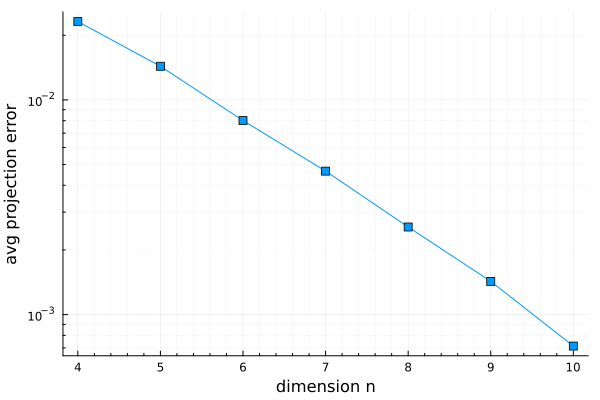

In [8]:
# Projection error
plot(df.order, df.projection_err, marker=(:rect))
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=false)
tmp = log10.(df.projection_err)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(df.order)
xlabel!("dimension n")
ylabel!("avg projection error")

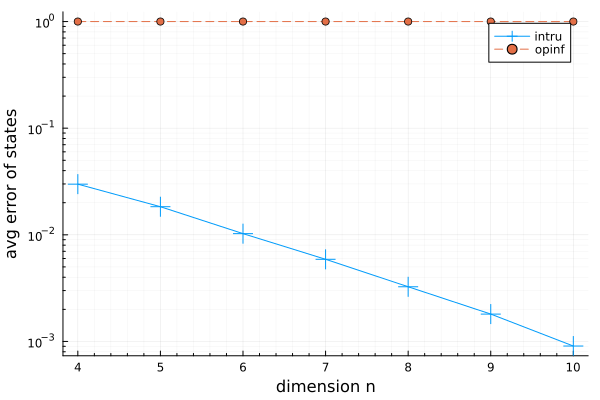

In [9]:
# State errors
plot(df.order, df.intrusive_state_err, marker=(:cross, 10), label="intru")
plot!(df.order, df.inferred_state_err, marker=(:circle), ls=:dash, label="opinf")
plot!(yscale=:log10, majorgrid=true, minorgrid=true)

yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(df.order)
xlabel!("dimension n")
ylabel!("avg error of states")

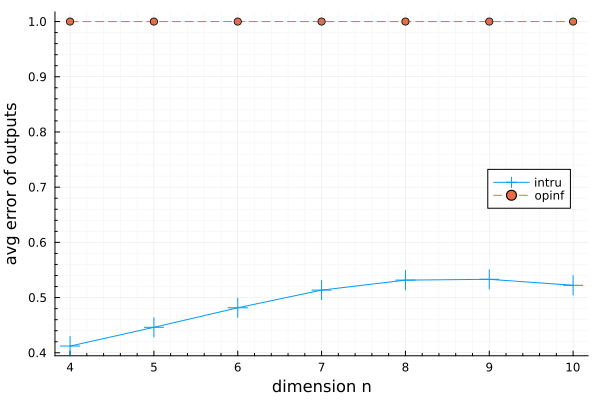

In [10]:
# Output errors
plot(df.order, df.intrusive_output_err, marker=(:cross, 10), label="intru")
plot!(df.order, df.inferred_output_err, marker=(:circle), ls=:dash, label="opinf")
plot!(majorgrid=true, minorgrid=true, legend=:right)
xticks!(df.order)
xlabel!("dimension n")
ylabel!("avg error of outputs")

In [11]:
tmp1 = DataFrame([4:rmax], [:order])
tmp2 = DataFrame(opinf_state_err, :auto)
df2 = hcat(tmp1, tmp2)
rename!(
    df2,
    [:x1,:x2,:x3,:x4,:x5,:x6,:x7,:x8,:x9,:x10] .=> Symbol.(burger.μs)
)

ArgumentError: ArgumentError: Tried renaming to :0.1 multiple times.

The NaN for r=15 and $\mu$=1 is causing the dip for the last point. Also, we can see that for $\mu$=1,2 where the diffusion is small, the relative state errors are higher.